# Ringtrial

> Evaluation Resnet 18 pre-trained on OSSL dataset on ringtrial data.


To do:

    - for each lab, fine-tune and eval on test set
      - use TTA and at what n it starts leveling off?
      - increase progressively train, valid, test set sizes
    - normalize on ringtrial statistics

## Runpod setup

In [ ]:
# setting up pod and pip install uhina
# accessing a pod terminal

# 1. To get access to the pod ip adress: runpodctl get pod -a
# 2. ssh into the pod: ssh root@<ip-address> -p 58871 -i ~/.ssh/id_ed25519

# git clone https://github.com/franckalbinet/uhina.git
# pip install uhina
# runpodctl send im-bw 
# runpodctl send ossl-tfm.csv


## Loading data

In [ ]:
import pandas as pd
from pathlib import Path
import fastcore.all as fc

from fastai.data.all import *
from fastai.vision.all import *
from multiprocessing import cpu_count
from sklearn.metrics import r2_score
from uhina.augment import Quantize

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)

In [ ]:
src = '../../_data/ringtrial-tfm/im-targets-lut.csv'
df = pd.read_csv(src)
df['lab'] = df['fname'].str.split('-rt', n=1).str[0]
df.head()

,fname,potassium_cmolkg,lab
0,agrocares-rt-01.png,0.26906,agrocares
1,agrocares-rt-02.png,0.23349,agrocares
2,agrocares-rt-03.png,0.29109,agrocares
3,agrocares-rt-04.png,0.49925,agrocares
4,agrocares-rt-05.png,0.59977,agrocares


In [ ]:
df['potassium_cmolkg'] = df['potassium_cmolkg'].apply(np.log1p)

## Fine-tuning on ringtrial

In [ ]:
class OrderedQuantize(Quantize):
    order = 0  # Apply first

class OrderedRatioResize(RatioResize):
    order = 1  # Apply second

In [ ]:
# learn = load_learner('./models/650-4000-epoch-25-lr-3e-3.pkl', cpu=True)
# learn = load_learner('./models/unfrozen-epoch-30-lr-1.5e-3-12102024.pkl', cpu=True)
# learn = load_learner('./models/unfrozen-epoch-30-lr-1.5e-3-12102024.pkl', cpu=True)
learn = load_learner('./models/frozen-epoch-30-lr-1.5e-3-12102024.pkl', cpu=True)

In [ ]:
df.lab.unique()

array(['agrocares', 'argonne', 'csu-il', 'eth-alpha-1', 'eth-alpha-2',
       'eth-vertex', 'iaea-aug2022', 'kssl', 'landcare', 'lesotho', 'msu',
       'osu', 'rothamsted', 'scion', 'ughent', 'uiuc', 'usp',
       'uwisc-fine', 'woodwell-alpha', 'woodwell-vertex'], dtype=object)

In [ ]:
# np.expm1(np.log1p(2))
df_selected = df[df.lab == 'kssl']
df_selected.head()

,fname,potassium_cmolkg,lab
483,kssl-rt-01.png,0.238276,kssl
484,kssl-rt-02.png,0.209848,kssl
485,kssl-rt-03.png,0.255487,kssl
486,kssl-rt-04.png,0.404965,kssl
487,kssl-rt-05.png,0.469860,kssl


In [ ]:
# def splitter(items): return [idx_train, idx_valid]
  
eval_on_pretrained = False
if eval_on_pretrained:  
    dblock = DataBlock(
        blocks=(ImageBlock, RegressionBlock),
        get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
        get_y=ColReader(1),
        # splitter=splitter,
        splitter=RandomSplitter(valid_pct=0, seed=41),
        item_tfms=[OrderedQuantize(n_valid=len(df_selected))],
        batch_tfms=[
            OrderedRatioResize(224),
            Normalize.from_stats(*imagenet_stats)
        ]
    )
    dls = dblock.dataloaders(df_selected, bs=len(df_selected))
    val_preds, val_targets = learn.get_preds(dl=dls.train)
    r2 = r2_score(val_targets, val_preds)
    print(r2)

In [ ]:
# Eval on pre-trained model
# eval_on_pretrained = True
# if eval_on_pretrained:
#     dblock = DataBlock(
#         blocks=(ImageBlock, RegressionBlock),
#         get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
#         get_y=ColReader(1),
#         splitter=RandomSplitter(valid_pct=0, seed=41),
#         batch_tfms=[RatioResize(224)],
#         item_tfms=[Quantize(n_valid=len(df_selected))])

#     dls = dblock.dataloaders(df_selected, bs=len(df_selected))
#     val_preds, val_targets = learn.get_preds(dl=dls.train)
#     r2 = r2_score(val_targets, val_preds)
#     print(r2)

In [ ]:
df_selected.loc[:, 'potassium_cmolkg'] = df_selected['potassium_cmolkg'].apply(np.log1p)
df_selected.head()

,fname,potassium_cmolkg,lab
483,kssl-rt-01.png,0.213720,kssl
484,kssl-rt-02.png,0.190494,kssl
485,kssl-rt-03.png,0.227523,kssl
486,kssl-rt-04.png,0.340012,kssl
487,kssl-rt-05.png,0.385167,kssl


In [ ]:
df_selected

,fname,potassium_cmolkg,lab
483,kssl-rt-01.png,0.213720,kssl
484,kssl-rt-02.png,0.190494,kssl
485,kssl-rt-03.png,0.227523,kssl
486,kssl-rt-04.png,0.340012,kssl
487,kssl-rt-05.png,0.385167,kssl
488,kssl-rt-06.png,0.402441,kssl
489,kssl-rt-07.png,0.331974,kssl
490,kssl-rt-08.png,0.101317,kssl
491,kssl-rt-09.png,0.681530,kssl
492,kssl-rt-10.png,0.274231,kssl


<Axes: >

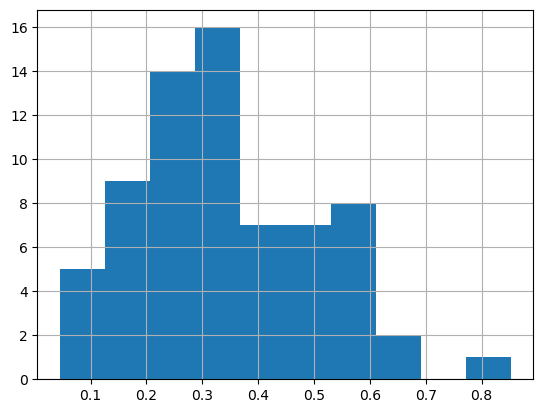

In [ ]:
df_selected['potassium_cmolkg'].hist()

### Train/valid/test split

#### Using Kennard-Stone

In [ ]:
df.lab.unique()

array(['agrocares', 'argonne', 'csu-il', 'eth-alpha-1', 'eth-alpha-2',
       'eth-vertex', 'iaea-aug2022', 'kssl', 'landcare', 'lesotho', 'msu',
       'osu', 'rothamsted', 'scion', 'ughent', 'uiuc', 'usp',
       'uwisc-fine', 'woodwell-alpha', 'woodwell-vertex'], dtype=object)

In [ ]:
df_selected = df[df.lab == 'kssl']

In [ ]:
len(df_selected)

69

In [ ]:
from uhina.loading import LoaderFactory

src = Path.home() / 'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001'
loader = LoaderFactory.get_loader(src, 'ringtrial')
data = loader.load_data(analytes='potassium_cmolkg')
print(f'X shape: {data.X.shape}')

X shape: (1400, 1676)


In [ ]:
# 44 is missing
indices_df = [name.split('.png')[0] for name in df_selected.fname]; indices_df

['kssl-rt-01',
 'kssl-rt-02',
 'kssl-rt-03',
 'kssl-rt-04',
 'kssl-rt-05',
 'kssl-rt-06',
 'kssl-rt-07',
 'kssl-rt-08',
 'kssl-rt-09',
 'kssl-rt-10',
 'kssl-rt-11',
 'kssl-rt-12',
 'kssl-rt-13',
 'kssl-rt-14',
 'kssl-rt-15',
 'kssl-rt-16',
 'kssl-rt-17',
 'kssl-rt-18',
 'kssl-rt-19',
 'kssl-rt-20',
 'kssl-rt-21',
 'kssl-rt-22',
 'kssl-rt-23',
 'kssl-rt-24',
 'kssl-rt-25',
 'kssl-rt-26',
 'kssl-rt-27',
 'kssl-rt-28',
 'kssl-rt-29',
 'kssl-rt-30',
 'kssl-rt-31',
 'kssl-rt-32',
 'kssl-rt-33',
 'kssl-rt-34',
 'kssl-rt-35',
 'kssl-rt-36',
 'kssl-rt-37',
 'kssl-rt-38',
 'kssl-rt-39',
 'kssl-rt-40',
 'kssl-rt-41',
 'kssl-rt-42',
 'kssl-rt-43',
 'kssl-rt-45',
 'kssl-rt-46',
 'kssl-rt-47',
 'kssl-rt-48',
 'kssl-rt-49',
 'kssl-rt-50',
 'kssl-rt-51',
 'kssl-rt-52',
 'kssl-rt-53',
 'kssl-rt-54',
 'kssl-rt-55',
 'kssl-rt-56',
 'kssl-rt-57',
 'kssl-rt-58',
 'kssl-rt-59',
 'kssl-rt-60',
 'kssl-rt-61',
 'kssl-rt-62',
 'kssl-rt-63',
 'kssl-rt-64',
 'kssl-rt-65',
 'kssl-rt-66',
 'kssl-rt-67',
 'kssl-rt-

In [ ]:
mask = np.isin(data.sample_indices, np.array(indices_df))

In [ ]:
data.sample_indices[mask]

array(['kssl-rt-01', 'kssl-rt-02', 'kssl-rt-03', 'kssl-rt-04',
       'kssl-rt-05', 'kssl-rt-06', 'kssl-rt-07', 'kssl-rt-08',
       'kssl-rt-09', 'kssl-rt-10', 'kssl-rt-11', 'kssl-rt-12',
       'kssl-rt-13', 'kssl-rt-14', 'kssl-rt-15', 'kssl-rt-16',
       'kssl-rt-17', 'kssl-rt-18', 'kssl-rt-19', 'kssl-rt-20',
       'kssl-rt-21', 'kssl-rt-22', 'kssl-rt-23', 'kssl-rt-24',
       'kssl-rt-25', 'kssl-rt-26', 'kssl-rt-27', 'kssl-rt-28',
       'kssl-rt-29', 'kssl-rt-30', 'kssl-rt-31', 'kssl-rt-32',
       'kssl-rt-33', 'kssl-rt-34', 'kssl-rt-35', 'kssl-rt-36',
       'kssl-rt-37', 'kssl-rt-38', 'kssl-rt-39', 'kssl-rt-40',
       'kssl-rt-41', 'kssl-rt-42', 'kssl-rt-43', 'kssl-rt-45',
       'kssl-rt-46', 'kssl-rt-47', 'kssl-rt-48', 'kssl-rt-49',
       'kssl-rt-50', 'kssl-rt-51', 'kssl-rt-52', 'kssl-rt-53',
       'kssl-rt-54', 'kssl-rt-55', 'kssl-rt-56', 'kssl-rt-57',
       'kssl-rt-58', 'kssl-rt-59', 'kssl-rt-60', 'kssl-rt-61',
       'kssl-rt-62', 'kssl-rt-63', 'kssl-rt-64', 'kssl-

In [ ]:
data.sample_indices[mask]

array(['kssl-rt-01', 'kssl-rt-02', 'kssl-rt-03', 'kssl-rt-04',
       'kssl-rt-05', 'kssl-rt-06', 'kssl-rt-07', 'kssl-rt-08',
       'kssl-rt-09', 'kssl-rt-10', 'kssl-rt-11', 'kssl-rt-12',
       'kssl-rt-13', 'kssl-rt-14', 'kssl-rt-15', 'kssl-rt-16',
       'kssl-rt-17', 'kssl-rt-18', 'kssl-rt-19', 'kssl-rt-20',
       'kssl-rt-21', 'kssl-rt-22', 'kssl-rt-23', 'kssl-rt-24',
       'kssl-rt-25', 'kssl-rt-26', 'kssl-rt-27', 'kssl-rt-28',
       'kssl-rt-29', 'kssl-rt-30', 'kssl-rt-31', 'kssl-rt-32',
       'kssl-rt-33', 'kssl-rt-34', 'kssl-rt-35', 'kssl-rt-36',
       'kssl-rt-37', 'kssl-rt-38', 'kssl-rt-39', 'kssl-rt-40',
       'kssl-rt-41', 'kssl-rt-42', 'kssl-rt-43', 'kssl-rt-45',
       'kssl-rt-46', 'kssl-rt-47', 'kssl-rt-48', 'kssl-rt-49',
       'kssl-rt-50', 'kssl-rt-51', 'kssl-rt-52', 'kssl-rt-53',
       'kssl-rt-54', 'kssl-rt-55', 'kssl-rt-56', 'kssl-rt-57',
       'kssl-rt-58', 'kssl-rt-59', 'kssl-rt-60', 'kssl-rt-61',
       'kssl-rt-62', 'kssl-rt-63', 'kssl-rt-64', 'kssl-

In [ ]:
df_selected.reset_index(inplace=True, drop=True)

In [ ]:
data.sample_indices[mask]

array(['kssl-rt-01', 'kssl-rt-02', 'kssl-rt-03', 'kssl-rt-04',
       'kssl-rt-05', 'kssl-rt-06', 'kssl-rt-07', 'kssl-rt-08',
       'kssl-rt-09', 'kssl-rt-10', 'kssl-rt-11', 'kssl-rt-12',
       'kssl-rt-13', 'kssl-rt-14', 'kssl-rt-15', 'kssl-rt-16',
       'kssl-rt-17', 'kssl-rt-18', 'kssl-rt-19', 'kssl-rt-20',
       'kssl-rt-21', 'kssl-rt-22', 'kssl-rt-23', 'kssl-rt-24',
       'kssl-rt-25', 'kssl-rt-26', 'kssl-rt-27', 'kssl-rt-28',
       'kssl-rt-29', 'kssl-rt-30', 'kssl-rt-31', 'kssl-rt-32',
       'kssl-rt-33', 'kssl-rt-34', 'kssl-rt-35', 'kssl-rt-36',
       'kssl-rt-37', 'kssl-rt-38', 'kssl-rt-39', 'kssl-rt-40',
       'kssl-rt-41', 'kssl-rt-42', 'kssl-rt-43', 'kssl-rt-45',
       'kssl-rt-46', 'kssl-rt-47', 'kssl-rt-48', 'kssl-rt-49',
       'kssl-rt-50', 'kssl-rt-51', 'kssl-rt-52', 'kssl-rt-53',
       'kssl-rt-54', 'kssl-rt-55', 'kssl-rt-56', 'kssl-rt-57',
       'kssl-rt-58', 'kssl-rt-59', 'kssl-rt-60', 'kssl-rt-61',
       'kssl-rt-62', 'kssl-rt-63', 'kssl-rt-64', 'kssl-

In [ ]:
# mask = np.char.find(data.sample_indices.astype(str), 'kssl') != -1
X_lab, y_lab = data.X[mask], np.log1p(data.y[mask])

In [ ]:
data.sample_indices[mask]

array(['kssl-rt-01', 'kssl-rt-02', 'kssl-rt-03', 'kssl-rt-04',
       'kssl-rt-05', 'kssl-rt-06', 'kssl-rt-07', 'kssl-rt-08',
       'kssl-rt-09', 'kssl-rt-10', 'kssl-rt-11', 'kssl-rt-12',
       'kssl-rt-13', 'kssl-rt-14', 'kssl-rt-15', 'kssl-rt-16',
       'kssl-rt-17', 'kssl-rt-18', 'kssl-rt-19', 'kssl-rt-20',
       'kssl-rt-21', 'kssl-rt-22', 'kssl-rt-23', 'kssl-rt-24',
       'kssl-rt-25', 'kssl-rt-26', 'kssl-rt-27', 'kssl-rt-28',
       'kssl-rt-29', 'kssl-rt-30', 'kssl-rt-31', 'kssl-rt-32',
       'kssl-rt-33', 'kssl-rt-34', 'kssl-rt-35', 'kssl-rt-36',
       'kssl-rt-37', 'kssl-rt-38', 'kssl-rt-39', 'kssl-rt-40',
       'kssl-rt-41', 'kssl-rt-42', 'kssl-rt-43', 'kssl-rt-45',
       'kssl-rt-46', 'kssl-rt-47', 'kssl-rt-48', 'kssl-rt-49',
       'kssl-rt-50', 'kssl-rt-51', 'kssl-rt-52', 'kssl-rt-53',
       'kssl-rt-54', 'kssl-rt-55', 'kssl-rt-56', 'kssl-rt-57',
       'kssl-rt-58', 'kssl-rt-59', 'kssl-rt-60', 'kssl-rt-61',
       'kssl-rt-62', 'kssl-rt-63', 'kssl-rt-64', 'kssl-

In [ ]:
df_selected

,fname,potassium_cmolkg,lab
0,kssl-rt-01.png,0.238276,kssl
1,kssl-rt-02.png,0.209848,kssl
2,kssl-rt-03.png,0.255487,kssl
3,kssl-rt-04.png,0.404965,kssl
4,kssl-rt-05.png,0.469860,kssl
5,kssl-rt-06.png,0.495470,kssl
6,kssl-rt-07.png,0.393716,kssl
7,kssl-rt-08.png,0.106628,kssl
8,kssl-rt-09.png,0.976900,kssl
9,kssl-rt-10.png,0.315519,kssl


In [ ]:
X_lab

array([[1.2708 , 1.26602, 1.26191, ..., 0.15597, 0.15574, 0.15549],
       [1.68078, 1.69329, 1.70438, ..., 0.22922, 0.22891, 0.22859],
       [1.69767, 1.69935, 1.70112, ..., 0.38133, 0.38056, 0.3798 ],
       ...,
       [1.65483, 1.65777, 1.6626 , ..., 0.22134, 0.22078, 0.2202 ],
       [1.86684, 1.86213, 1.85727, ..., 0.14837, 0.14783, 0.14725],
       [1.62302, 1.62296, 1.62328, ..., 0.2393 , 0.23909, 0.23888]])

In [ ]:
from uhina.preprocessing import SNV, TakeDerivative
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('SNV', SNV()),
    ('Derivative', TakeDerivative())
])

X_lab_trans = pipe.fit_transform(X_lab)

In [ ]:
df_selected

,fname,potassium_cmolkg,lab
0,kssl-rt-01.png,0.238276,kssl
1,kssl-rt-02.png,0.209848,kssl
2,kssl-rt-03.png,0.255487,kssl
3,kssl-rt-04.png,0.404965,kssl
4,kssl-rt-05.png,0.469860,kssl
5,kssl-rt-06.png,0.495470,kssl
6,kssl-rt-07.png,0.393716,kssl
7,kssl-rt-08.png,0.106628,kssl
8,kssl-rt-09.png,0.976900,kssl
9,kssl-rt-10.png,0.315519,kssl


In [ ]:
X_lab_trans.shape

(69, 1676)

In [ ]:
import kennard_stone as ks

# train_idx, valid_idx, X_train, X_valid = ks.train_test_split(np.array(range(len(X_lab_trans))).reshape(-1, 1), 
#                                                              X_lab_trans, test_size = 0.2)

# train_idx = train_idx.ravel()
# valid_idx = valid_idx.ravel()
X_train, X_valid, train_idx, valid_idx = ks.train_test_split(X_lab_trans, 
                                                             range(len(X_lab_trans)), 
                                                             test_size = 0.2)

Calculating pairwise distances using scikit-learn.
Calculating pairwise distances using scikit-learn.


In [ ]:
valid_idx

[35, 6, 24, 12, 3, 31, 30, 5, 2, 25, 49, 28, 44, 40]

<Axes: >

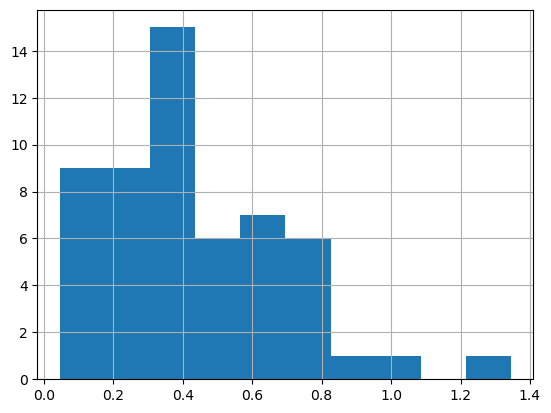

In [ ]:
df_selected.loc[train_idx, :]['potassium_cmolkg'].hist()

<Axes: >

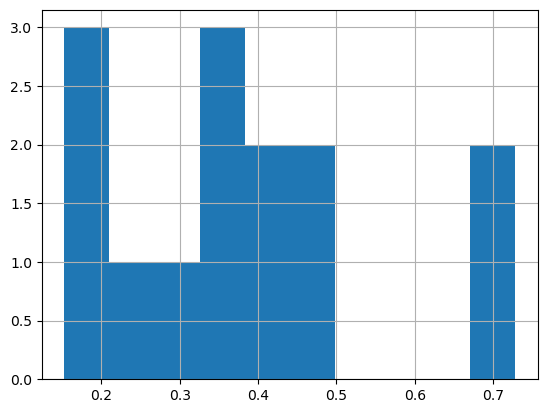

In [ ]:
df_selected.loc[valid_idx, :]['potassium_cmolkg'].hist()

1 0.9167139331659132
2 0.8169940843443368
3 0.8201480463134329
4 0.8330463354402591
5 0.8336164418584839
6 0.8066819139016866
7 0.8063689082131712
8 0.8476483270390328
9 0.8442719648387733
10 0.8550880328401899
11 0.85550155049048
12 0.8773457853046793
13 0.8640833529184554
14 0.8467865332449903
15 0.8598890265246808
16 0.860227416062531
17 0.8890976617393181
18 0.8975066928044428
19 0.9022963785020354


[<matplotlib.lines.Line2D>]

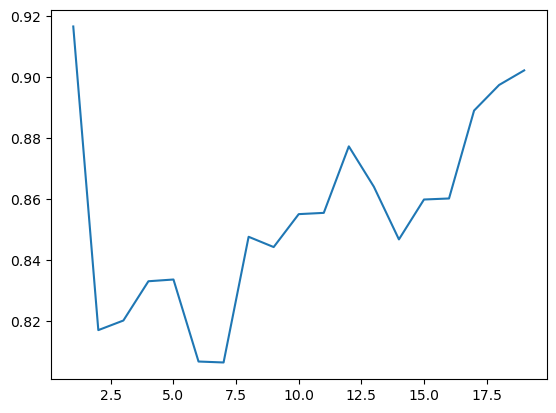

In [ ]:
from sklearn.cross_decomposition import PLSRegression
scores = []
for n in range(1,20):
    pls = PLSRegression(n_components=n)
    pls.fit(X_lab_trans[train_idx], y_lab[train_idx])
    y_predicted = pls.predict(X_lab_trans[valid_idx])
    print(n, r2_score(y_predicted, y_lab[valid_idx]))
    scores.append(r2_score(y_predicted, y_lab[valid_idx]))

plt.plot(range(1, 20), scores)

In [ ]:
pls = PLSRegression(n_components=1)
pls.fit(X_lab_trans[train_idx], np.log1p(data.y[mask][train_idx]))
y_predicted = pls.predict(X_lab_trans[valid_idx])

[<matplotlib.lines.Line2D>]

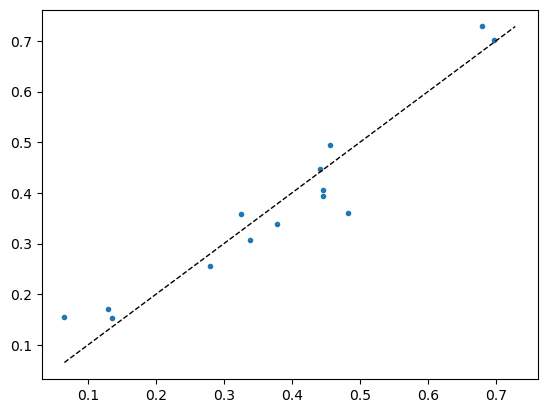

In [ ]:
x, y = y_predicted, np.log1p(data.y[mask][valid_idx])
plt.plot(x, y, '.')
# Add the diagonal line
min_val = min(y.min(), x.min())
max_val = max(y.max(), x.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

In [ ]:
# dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
#                    get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
#                    get_y=ColReader(1),
#                    splitter=RandomSplitter(valid_pct=0, seed=41),
#                    batch_tfms=[RatioResize(224)],
#                    item_tfms=[Quantize()])

In [ ]:
# class ModelEvaluator:
#     def __init__(self, model_path, dblock):
#         self.learn = load_learner(model_path, cpu=True)
#         self.dblock = dblock

#     def evaluate(self, df_selected, batch_size=16, use_tta=False, tta_n=4):
#         dls = self.dblock.dataloaders(df_selected, bs=batch_size)
#         if use_tta:
#             val_preds, val_targets = self.learn.tta(dl=dls.train, n=tta_n)
#         else:
#             val_preds, val_targets = self.learn.get_preds(dl=dls.train)
        
#         r2 = r2_score(val_targets, val_preds)
#         return val_preds, val_targets, r2

In [ ]:
# model_path = './models/650-4000-epoch-25-lr-3e-3.pkl'
# evaluator = ModelEvaluator(model_path, dblock)

In [ ]:
len(train_idx), len(valid_idx)

(55, 14)

In [ ]:
def has_common_elements(list1, list2): return bool(set(list1) & set(list2))
fc.test_eq(has_common_elements(train_idx, valid_idx), False)

In [ ]:
df_selected

,fname,potassium_cmolkg,lab
0,eth-alpha-1-rt-01.png,0.238276,eth-alpha-1
1,eth-alpha-1-rt-02.png,0.209848,eth-alpha-1
2,eth-alpha-1-rt-03.png,0.255487,eth-alpha-1
3,eth-alpha-1-rt-04.png,0.404965,eth-alpha-1
4,eth-alpha-1-rt-05.png,0.469860,eth-alpha-1
5,eth-alpha-1-rt-06.png,0.495470,eth-alpha-1
6,eth-alpha-1-rt-07.png,0.393716,eth-alpha-1
7,eth-alpha-1-rt-08.png,0.106628,eth-alpha-1
8,eth-alpha-1-rt-09.png,0.976900,eth-alpha-1
9,eth-alpha-1-rt-10.png,0.315519,eth-alpha-1


In [ ]:
df_selected.loc[train_idx, :]

,fname,potassium_cmolkg,lab
15,eth-alpha-1-rt-16.png,0.662054,eth-alpha-1
16,eth-alpha-1-rt-17.png,0.595782,eth-alpha-1
46,eth-alpha-1-rt-48.png,0.724215,eth-alpha-1
49,eth-alpha-1-rt-51.png,0.728205,eth-alpha-1
48,eth-alpha-1-rt-50.png,0.720475,eth-alpha-1
59,eth-alpha-1-rt-61.png,0.461032,eth-alpha-1
47,eth-alpha-1-rt-49.png,0.442131,eth-alpha-1
54,eth-alpha-1-rt-56.png,0.718293,eth-alpha-1
39,eth-alpha-1-rt-40.png,0.673883,eth-alpha-1
36,eth-alpha-1-rt-37.png,0.134627,eth-alpha-1


In [ ]:
def ks_splitter(items): return [train_idx, valid_idx]

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
    get_y=ColReader(1),
    splitter = ks_splitter,
    item_tfms=[OrderedQuantize(n_valid=len(valid_idx))],
    batch_tfms=[
    OrderedRatioResize(224),
    Normalize.from_stats(*imagenet_stats)
    ]
)
dls = dblock.dataloaders(df_selected, bs=16)

learn = load_learner('./models/frozen-epoch-30-lr-1.5e-3-12102024.pkl', cpu=True)
learn.dls = dls
learn.freeze()

SuggestedLRs(valley=0.001737800776027143)

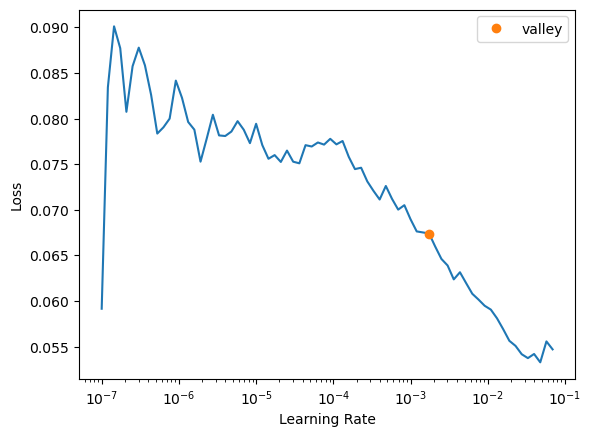

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1.5e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.062678,0.070659,-7.250715,00:02
1,0.060883,0.032091,-2.747149,00:01
2,0.064407,0.013675,-0.596789,00:01
3,0.052951,0.005511,0.356464,00:01
4,0.048459,0.005013,0.414687,00:01
5,0.043682,0.005526,0.354736,00:01
6,0.039910,0.006038,0.294921,00:02
7,0.036788,0.006592,0.230292,00:01
8,0.034137,0.006361,0.257186,00:01
9,0.032073,0.006753,0.211423,00:01


In [ ]:
# val_preds, val_targets = learn.get_preds(dl=dls.valid)
val_preds, val_targets = learn.tta(dl=dls.valid, n=30)
r2_score(val_targets, val_preds)

0.8524203732220106

[<matplotlib.lines.Line2D>]

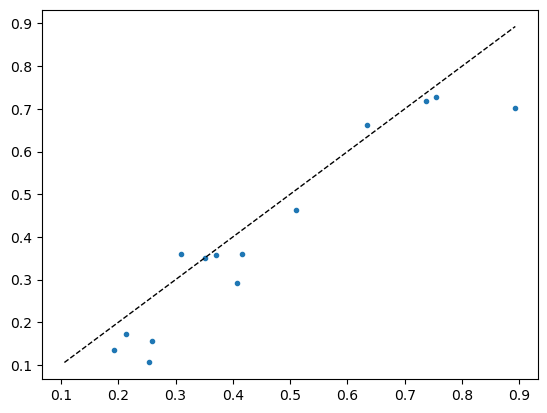

In [ ]:
x, y = val_preds, val_targets
plt.plot(x, y, '.')
# Add the diagonal line
min_val = min(y.min(), x.min())
max_val = max(y.max(), x.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

#### Using cross-validation

In [ ]:
def cross_validation(df, target, valid_size=0.2, 
                     num_bins=2, epochs=1, lr=1.5e-3, 
                     n_tta=10, seed=31):
    from sklearn.model_selection import train_test_split
    df = df.copy()
    df.reset_index(inplace=True, drop=True)
    train_df, valid_df = train_test_split(df, test_size=valid_size, 
                                          stratify=pd.qcut(df[target], q=num_bins, labels=False), 
                                          random_state=seed)
    
    train_idx, valid_idx = train_df.index, valid_df.index
    
    def stratified_splitter(items): return [train_idx, valid_idx]
   
    dblock = DataBlock(
        blocks=(ImageBlock, RegressionBlock),
        get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
        get_y=ColReader(1),
        splitter=stratified_splitter,
        item_tfms=[OrderedQuantize(n_valid=len(valid_idx))],
        batch_tfms=[
        OrderedRatioResize(224),
        Normalize.from_stats(*imagenet_stats)
        ]
    )
    dls = dblock.dataloaders(df, bs=16)
    learn = load_learner('./models/frozen-epoch-30-lr-1.5e-3-12102024.pkl', cpu=True)
    learn.dls = dls
    learn.freeze()
    learn.fit_one_cycle(epochs, lr)
    # val_preds, val_targets = learn.get_preds(dl=dls.valid)
    val_preds, val_targets = learn.tta(dl=dls.valid, n=n_tta)
    return r2_score(val_targets, val_preds)

In [ ]:
df_selected = df[df.lab == 'kssl']
scores = []
for seed in range(1, 10):
    score = cross_validation(df_selected, 'potassium_cmolkg', 
                             valid_size=0.2, num_bins=4, 
                             epochs=3, seed=seed)
    scores.append(score )
    

epoch,train_loss,valid_loss,r2_score,time
0,0.080839,0.318125,0.302815,00:02
1,0.073392,0.298006,0.346907,00:01
2,0.065199,0.292256,0.359508,00:01


epoch,train_loss,valid_loss,r2_score,time
0,0.078712,0.058278,0.567448,00:01
1,0.103297,0.037975,0.718140,00:01
2,0.106955,0.029388,0.781878,00:01


epoch,train_loss,valid_loss,r2_score,time
0,0.040163,0.132989,0.170330,00:02
1,0.085821,0.117681,0.265833,00:02
2,0.085760,0.110825,0.308603,00:02


epoch,train_loss,valid_loss,r2_score,time
0,0.073621,0.045193,0.553941,00:02
1,0.106387,0.029305,0.710762,00:03
2,0.082117,0.021391,0.788873,00:02


epoch,train_loss,valid_loss,r2_score,time
0,0.077322,0.299385,0.362233,00:02
1,0.071211,0.292716,0.376440,00:01
2,0.061952,0.281709,0.399887,00:01


epoch,train_loss,valid_loss,r2_score,time
0,0.155731,0.052831,0.586981,00:02
1,0.147657,0.045921,0.641001,00:03
2,0.127009,0.043383,0.660838,00:02


epoch,train_loss,valid_loss,r2_score,time
0,0.130341,0.135900,0.309171,00:01
1,0.119079,0.105886,0.461744,00:01
2,0.102005,0.097154,0.506130,00:01


epoch,train_loss,valid_loss,r2_score,time
0,0.159416,0.036709,0.643722,00:02
1,0.147401,0.028988,0.718660,00:02
2,0.133312,0.023979,0.767270,00:01


epoch,train_loss,valid_loss,r2_score,time
0,0.186754,0.042557,0.596722,00:01
1,0.122767,0.023109,0.781009,00:01
2,0.114166,0.018596,0.823780,00:01


(array([1., 1., 1., 0., 1., 0., 0., 1., 0., 4.]),
 array([0.26426539, 0.31865215, 0.37303891, 0.42742567, 0.48181243,
        0.53619919, 0.59058595, 0.64497271, 0.69935947, 0.75374623,
        0.80813299]),
 <BarContainer object of 10 artists>)

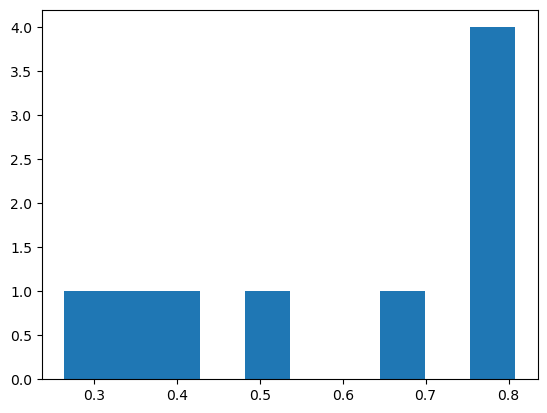

In [ ]:
plt.hist(np.array(scores))

In [ ]:
def stratified_split(df, target, valid_size=0.2, test_size=0.2, num_bins=2, seed=41):
    from sklearn.model_selection import train_test_split
    df = df.copy()
    df.reset_index(inplace=True, drop=True)
    train_df, test_df = train_test_split(df, test_size=test_size, 
                                        stratify=pd.qcut(df[target], q=num_bins, labels=False), 
                                        random_state=seed)

    train_df, valid_df = train_test_split(train_df, test_size=test_size, 
                                        stratify=pd.qcut(train_df[target], q=num_bins, labels=False), 
                                        random_state=seed)
    
    return train_df, train_df.index, valid_df, valid_df.index, test_df, test_df.index

In [ ]:
data = stratified_split(df_selected, 'potassium_cmolkg', valid_size=0.3, test_size=0.2, num_bins=2)
train_df, train_idx, valid_df, valid_idx, test_df, test_idx = data

In [ ]:
# Check they have nothing in common
def has_common_elements(list1, list2): return bool(set(list1) & set(list2))

fc.test_eq(has_common_elements(train_idx, test_idx), False)
fc.test_eq(has_common_elements(train_idx, valid_idx), False)
fc.test_eq(has_common_elements(test_idx, valid_idx), False)

AssertionError: ==:
True
False

In [ ]:
train_idx, valid_idx

(Index([26, 40, 17, 67, 22, 13, 16, 41, 49, 18,  2,  9, 47, 44, 52, 63, 61, 37,
        57, 59, 66, 30, 54, 33,  7, 55, 15, 46, 19, 53, 29, 60,  4,  3, 64, 45,
        11, 20],
       dtype='int64'),
 Index([21, 58, 14, 65, 34, 56, 50, 6, 35, 62, 68, 32, 25, 24, 43, 10, 48], dtype='int64'))

In [ ]:
len(train_df), len(valid_df), len(test_df)

(38, 17, 14)

In [ ]:
test_df

,fname,potassium_cmolkg,lab
28,kssl-rt-29.png,0.306528,kssl
39,kssl-rt-40.png,0.673883,kssl
23,kssl-rt-24.png,0.173592,kssl
0,kssl-rt-01.png,0.238276,kssl
42,kssl-rt-43.png,0.262710,kssl
27,kssl-rt-28.png,0.676835,kssl
31,kssl-rt-32.png,0.338556,kssl
38,kssl-rt-39.png,0.396687,kssl
8,kssl-rt-09.png,0.976900,kssl
1,kssl-rt-02.png,0.209848,kssl


In [ ]:

def stratified_splitter(items): return [train_idx, valid_idx]

# dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
#                    get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
#                    get_y=ColReader(1),
#                    splitter=stratified_splitter,
#                    batch_tfms=[RatioResize(224)],
#                    item_tfms=[Quantize(n_valid=len(valid_idx))])

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
    get_y=ColReader(1),
    splitter=stratified_splitter,
    item_tfms=[OrderedQuantize(n_valid=len(valid_idx))],
    batch_tfms=[
        OrderedRatioResize(224),
        Normalize.from_stats(*imagenet_stats)
    ]
)

In [ ]:
# dblock.summary(df_selected)

Setting-up type transforms pipelines
483  kssl-rt-01.png          0.238276  kssl
484  kssl-rt-02.png          0.209848  kssl
485  kssl-rt-03.png          0.255487  kssl
486  kssl-rt-04.png          0.404965  kssl
487  kssl-rt-05.png          0.469860  kssl
488  kssl-rt-06.png          0.495470  kssl
489  kssl-rt-07.png          0.393716  kssl
490  kssl-rt-08.png          0.106628  kssl
491  kssl-rt-09.png          0.976900  kssl
492  kssl-rt-10.png          0.315519  kssl
493  kssl-rt-11.png          0.335250  kssl
494  kssl-rt-12.png          0.292252  kssl
495  kssl-rt-13.png          0.446620  kssl
496  kssl-rt-14.png          0.210804  kssl
497  kssl-rt-15.png          0.482117  kssl
498  kssl-rt-16.png          0.662054  kssl
499  kssl-rt-17.png          0.595782  kssl
500  kssl-rt-18.png          0.360761  kssl
501  kssl-rt-19.png          0.340229  kssl
502  kssl-rt-20.png          0.342816  kssl
503  kssl-rt-21.png          0.398024  kssl
504  kssl-rt-22.png          0.082409  

In [ ]:
dls = dblock.dataloaders(df_selected, bs=16)

In [ ]:
dls.train.n, dls.valid.n

(38, 17)

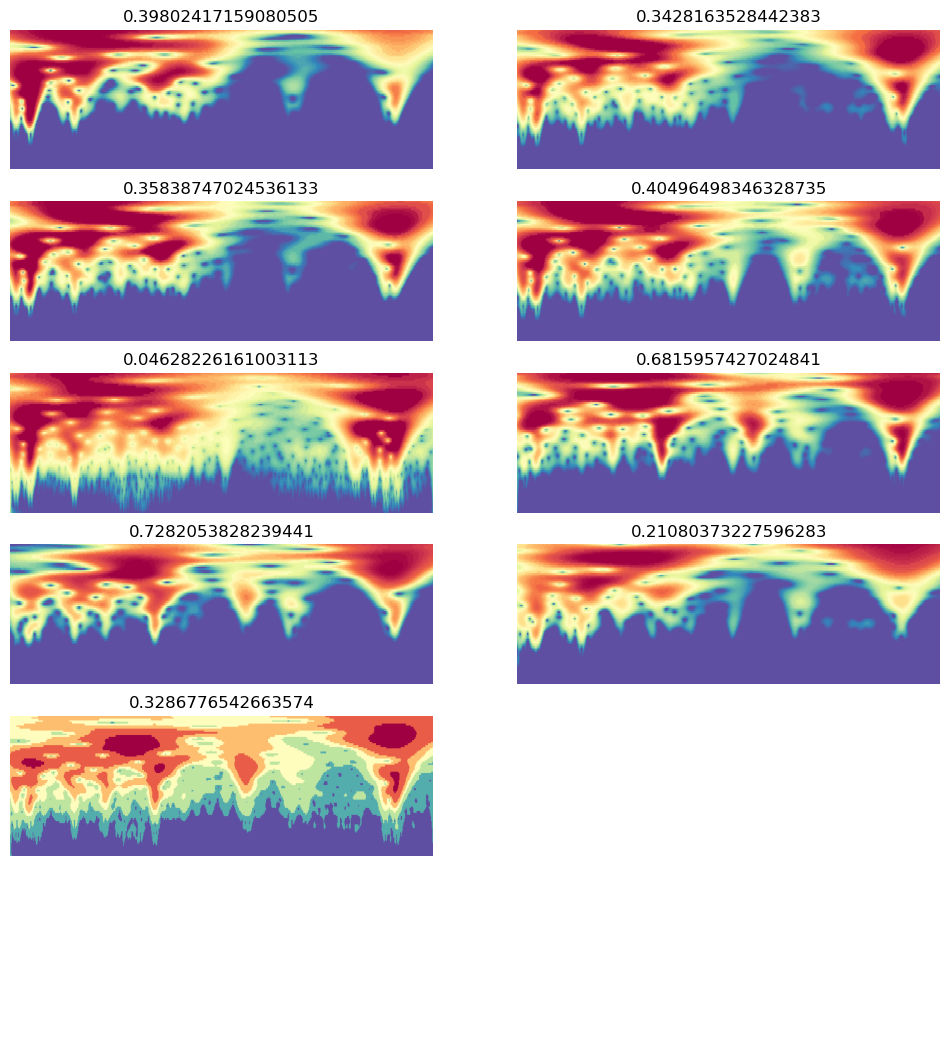

In [ ]:
dls.show_batch(nrows=6, ncols=2, figsize=(12, 13))

In [ ]:
learn.dls = dls

In [ ]:
# learn.summary()

In [ ]:
learn.freeze()

In [ ]:
# learn.summary()

SuggestedLRs(valley=0.0014454397605732083)

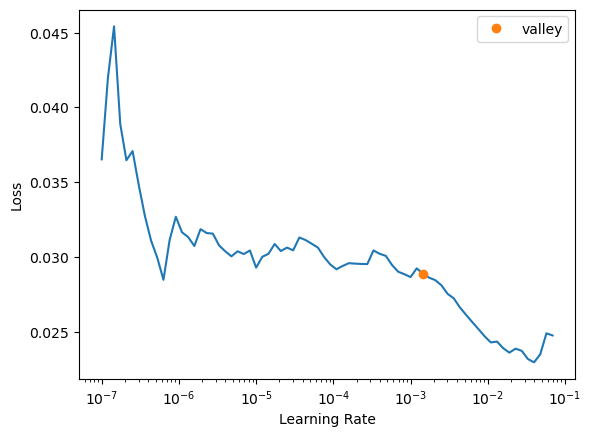

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1.5e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.033352,0.007514,0.877129,00:02


In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.valid)
r2_score(val_targets, val_preds)

InvalidParameterError: The 'y_true' parameter of r2_score must be an array-like. Got None instead.

### Evaluate fine-tuned model

In [ ]:
len(test_df)

14

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
                   get_y=ColReader(1),
                   splitter=RandomSplitter(valid_pct=0, seed=41),
                   item_tfms=[OrderedQuantize(n_valid=len(test_df))],
                   batch_tfms=[
                       OrderedRatioResize(224),
                       Normalize.from_stats(*imagenet_stats)]
                   )

dls = dblock.dataloaders(test_df, bs=len(test_df))

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)

In [ ]:
r2_score(val_targets, val_preds)

0.18065004067315227

In [ ]:
val_preds, val_targets = learn.tta(dl=dls.train, n=30)

In [ ]:
r2_score(val_targets, val_preds)

0.31174768615708437

In [ ]:
np.c_[val_preds, val_targets]

array([[0.28596842, 0.33855578],
       [0.34872288, 0.30652836],
       [0.16156155, 0.1735919 ],
       [0.15021066, 0.20984755],
       [0.7913804 , 0.6738828 ],
       [0.6016631 , 0.9769003 ],
       [0.12963496, 0.23827647],
       [0.476924  , 0.3966867 ],
       [0.41498667, 0.44661984],
       [0.3885079 , 0.26271036],
       [0.4440051 , 0.49547035],
       [0.1741274 , 0.13462704],
       [0.38449523, 0.40078753],
       [0.5929916 , 0.6768349 ]], dtype=float32)

| lab | lr | n_epochs (fine-tuning) | r2_score |  n_tta  |
|------|--------------|-------------------|----------|--------|
| iaea-aug2022 | 1.5e-3 | 20 | 0.867 | 30 |
| kssl | 1.5e-3 | 20 | 0.931 | 30 |

<!-- | kssl | 1e-3 | 5 | 0.89 | 30 |
| agrocares | 1e-3 | 20 | 0.75 | 30 |
| argonne | 1e-3 | 5 | 0.92 | 30 |

| csu-il | 1e-3 | 5 | 0.85 | 30 |
| eth-alpha-1 | 1e-3 | 30 | 0.93 | 30 |

 -->


In [ ]:
learn.predict('/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/kssl-rt-01.png')

((0.2232206165790558,), tensor([0.2232]), tensor([0.2232]))

In [ ]:
np.c_[val_preds, val_targets]

array([[0.573713  , 0.66205376],
       [0.23120013, 0.25548682],
       [0.29060498, 0.23827647],
       [0.3890785 , 0.3588835 ],
       [0.72690636, 0.6738828 ],
       [0.52095914, 0.48211747],
       [0.5956749 , 0.6768349 ],
       [0.55163294, 0.71829337],
       [0.41514462, 0.46985987],
       [0.6461811 , 0.73577553],
       [0.3656289 , 0.24990232],
       [0.6311119 , 0.68159574],
       [0.16741446, 0.1476956 ],
       [0.3227809 , 0.31551853]], dtype=float32)

[<matplotlib.lines.Line2D>]

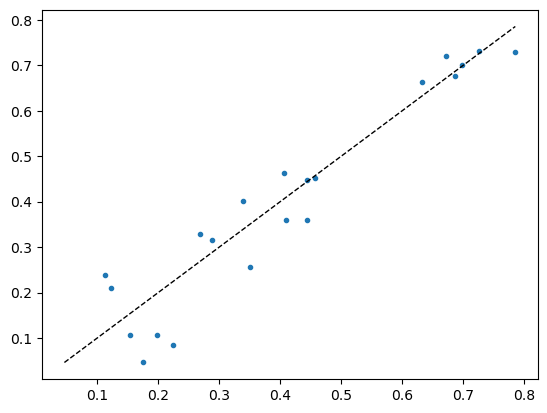

In [ ]:
x, y = val_preds, val_targets
plt.plot(x, y, '.')
# Add the diagonal line
min_val = min(y.min(), x.min())
max_val = max(y.max(), x.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

### On single images

In [ ]:
def predict_with_transforms(learn, img_path, n_predictions=5):
    # Load the image
    img = PILImage.create(img_path)
    
    # Create instances of the transforms
    ratio_resize = RatioResize(224)
    quantize = Quantize()
    
    predictions = []
    for _ in range(n_predictions):
        # Apply transforms
        img_resized = ratio_resize(img)
        img_quantized = quantize(img_resized)
        
        # Predict
        pred, _, _ = learn.predict(img_quantized)
        predictions.append(pred[0])
    
    from statistics import mode
    # Calculate mean and standard deviation
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    median_pred = np.median(predictions)
    mode_pred = mode(predictions)
    return mean_pred, std_pred, median_pred, mode_pred, predictions

In [ ]:
test_df

,fname,potassium_cmolkg,lab
416,iaea-aug2022-rt-03.png,0.255487,iaea-aug2022
453,iaea-aug2022-rt-40.png,0.673883,iaea-aug2022
414,iaea-aug2022-rt-01.png,0.238276,iaea-aug2022
441,iaea-aug2022-rt-28.png,0.676835,iaea-aug2022
470,iaea-aug2022-rt-58.png,0.735776,iaea-aug2022
423,iaea-aug2022-rt-10.png,0.315519,iaea-aug2022
429,iaea-aug2022-rt-16.png,0.662054,iaea-aug2022
468,iaea-aug2022-rt-56.png,0.718293,iaea-aug2022
428,iaea-aug2022-rt-15.png,0.482117,iaea-aug2022
467,iaea-aug2022-rt-55.png,0.358884,iaea-aug2022


In [ ]:
learn.predict('/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/iaea-aug2022-rt-03.png')

((0.22924283146858215,), tensor([0.2292]), tensor([0.2292]))

In [ ]:
def predict_with_tta_histogram(learn, img_path, n_tta=40):
    # Load the image
    img = PILImage.create(img_path)
    
    # Create a test DataLoader with a single image
    test_dl = learn.dls.test_dl([img])
    
    # Collect predictions
    all_preds = []
    for _ in range(n_tta):
        # Get prediction with TTA (n=1 for a single augmentation each time)
        preds, _ = learn.tta(dl=test_dl, n=1)
        all_preds.append(preds[0][0].item())  # Assuming single output
    
    all_preds = np.array(all_preds)
    
    # Calculate statistics
    mean_pred = np.mean(all_preds)
    std_pred = np.std(all_preds)
    median_pred = np.median(all_preds)
    
    return mean_pred, std_pred, median_pred, all_preds

Mean prediction: 0.2245
Standard deviation: 0.0293
Median prediction: 0.2370
All predictions: [0.2538105  0.20756826 0.16517167 0.18890977 0.23950726 0.25089669
 0.23727572 0.1606092  0.23708239 0.24203241 0.24409012 0.23063052
 0.22467479 0.22609089 0.21201754 0.24700734 0.24322104 0.1814348
 0.23694187 0.21401702 0.24518737 0.23962407 0.24665055 0.23783752
 0.23432088 0.13502732 0.24622732 0.22676304 0.24990481 0.23013265]
Ground truth: 0.29109


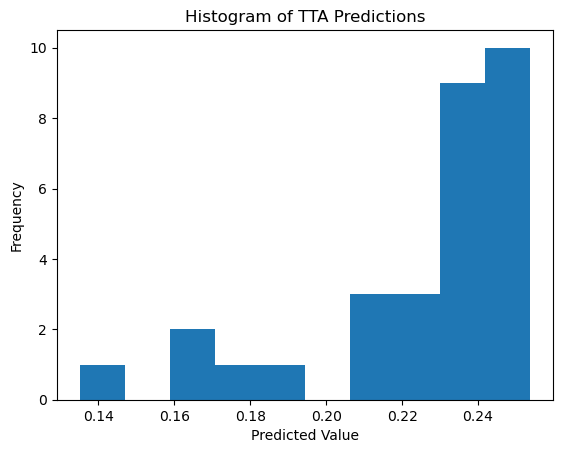

In [ ]:

# Use the function
fname = 'iaea-aug2022-rt-03.png'
img_path = Path('/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/') / fname
mean, std, median, all_preds = predict_with_tta_histogram(learn, img_path, n_tta=30)

print(f"Mean prediction: {mean:.4f}")
print(f"Standard deviation: {std:.4f}")
print(f"Median prediction: {median:.4f}")
print(f"All predictions: {all_preds}")

# If you want to compare with the ground truth
print('Ground truth:', df[df.fname == fname]['potassium_cmolkg'].values[0])

# Plot histogram
plt.hist(all_preds, bins=10)
plt.title('Histogram of TTA Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.plot(all_preds)

In [ ]:
# Canonical fine-tuning
# from fastai.vision.all import *

# # Load the pretrained model
# learn = load_learner('./models/650-4000-epoch-25-lr-3e-3.pkl', cpu=False)

# # Prepare your new data
# path = 'path/to/your/data'
# dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(224), batch_tfms=aug_transforms())

# # Set the new data
# learn.dls = dls

# # Fine-tune the head of the model
# learn.freeze()
# # alternatively: learn.freeze_to(n)
# learn.lr_find()
# learn.fit_one_cycle(5, 3e-3)

# # Fine-tune the entire model
# learn.unfreeze()
# learn.lr_find()
# learn.fit_one_cycle(5, slice(1e-5, 1e-3))

In [ ]:
# learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score()).to_fp16()


In [ ]:
# learn.lr_find()

SuggestedLRs(valley=0.002511886414140463)

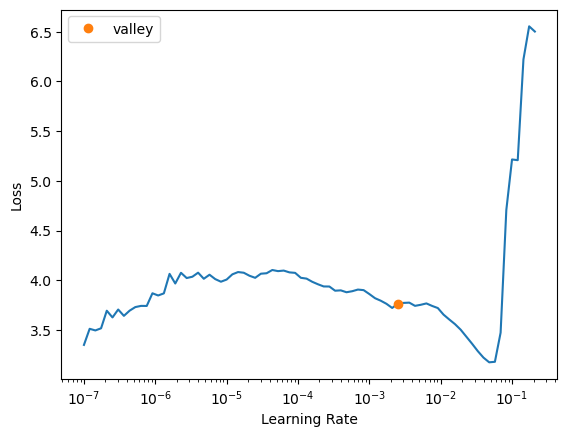

In [ ]:
# learn.lr_find()

In [ ]:
# learn.fit_one_cycle(5, 3e-3)

## Evaluation

In [ ]:
# Convert predictions and targets to numpy arrays
def assess_model(val_preds, val_targets):
    val_preds = val_preds.numpy().flatten()
    val_targets = val_targets.numpy()

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Predicted': val_preds,
        'Actual': val_targets
    })

    # Display the first few rows of the results
    print(results_df.head())

    # Calculate and print the R2 score
    from sklearn.metrics import r2_score
    r2 = r2_score(val_targets, val_preds)
    print(f"R2 Score on validation set: {r2:.4f}")

In [ ]:
dls.train.n

69

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)
assess_model(val_preds, val_targets)

   Predicted    Actual
0   0.046272  0.210804
1   0.528189  0.976900
2   0.465372  0.469860
3   0.258100  0.338556
4   0.112802  0.147696
R2 Score on validation set: 0.7392


In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)
r2 = r2_score(val_targets, val_preds); r2

In [ ]:
r2 = r2_score(val_targets, val_preds); r2

0.7391959435205914

In [ ]:
scores = []
for n in range(1, 20):
    val_preds, val_targets = learn.tta(dl=dls.train, n=n)
    scores.append(r2_score(val_targets, val_preds))

[<matplotlib.lines.Line2D>]

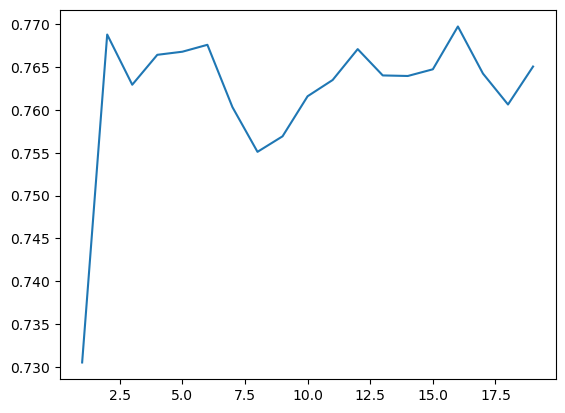

In [ ]:
x = list(range(1, 20))
plt.plot(x, scores)

In [ ]:
# EXAMPLE of TTA on single item
# from fastai.vision.all import *

# # Define your TTA transforms
# tta_tfms = [
#     RandomResizedCrop(224, min_scale=0.5),
#     Flip(),
#     Rotate(degrees=(-15, 15)),
#     Brightness(max_lighting=0.2),
#     Contrast(max_lighting=0.2)
# ]

# # Create a pipeline of TTA transformations
# tta_pipeline = Pipeline(tta_tfms)

# # Load your model
# learn = load_learner('path/to/your/model.pkl')

# # Define the input data (e.g., an image)
# input_data = PILImage.create('path/to/your/image.jpg')

# # Apply TTA transforms to the input data and make predictions
# predictions = []
# for _ in range(5):  # Apply 5 different augmentations
#     augmented_data = tta_pipeline(input_data)
#     prediction = learn.predict(augmented_data)
#     predictions.append(prediction)

# # Average the predictions
# average_prediction = sum(predictions) / len(predictions)

# print(average_prediction)

In [ ]:
# Assuming you have a new CSV file for your test data
# test_source = '../../_data/ossl-tfm/ossl-tfm-test.csv'
# test_df = pd.read_csv(test_source)

# # Create a new DataLoader for the test data
# test_dl = learn.dls.test_dl(test_df)

# # Get predictions on the test set
# test_preds, test_targets = learn.get_preds(dl=test_dl)

# # Now you can use test_preds and test_targets for further analysis

In [ ]:
assess_model(val_preds, val_targets)

   Predicted    Actual
0   0.312483  0.000000
1   0.126990  0.184960
2   0.365726  0.194201
3   0.239089  0.262364
4   0.402980  0.355799
R2 Score on validation set: 0.8325


In [ ]:
assess_model(val_preds_tta, val_targets_tta)

   Predicted    Actual
0   0.246857  0.000000
1   0.148590  0.184960
2   0.371643  0.194201
3   0.226535  0.262364
4   0.407333  0.355799
R2 Score on validation set: 0.8378


In [ ]:
val_preds_np = val_preds
val_targets_np = val_targets

# Apply the transformation: exp(y) - 1
val_preds_transformed = np.exp(val_preds_np) - 1
val_targets_transformed = np.exp(val_targets_np) - 1

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Predicted': val_preds_transformed,
    'Actual': val_targets_transformed
})

# Display the first few rows of the results
print(results_df.head())

# Calculate and print the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(val_targets_transformed, val_preds_transformed)
print(f"R2 Score on validation set (after transformation): {r2:.4f}")

# Calculate and print the MAPE, handling zero values
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%")

# Calculate and print the MAE as an alternative metric
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Error (MAE) on validation set: {mae:.4f}")

   Predicted   Actual
0   0.366814  0.00000
1   0.135405  0.20317
2   0.441560  0.21434
3   0.270092  0.30000
4   0.496277  0.42732
R2 Score on validation set (after transformation): 0.6936
Mean Absolute Percentage Error (MAPE) on validation set: 50.72%
Mean Absolute Error (MAE) on validation set: 0.1956


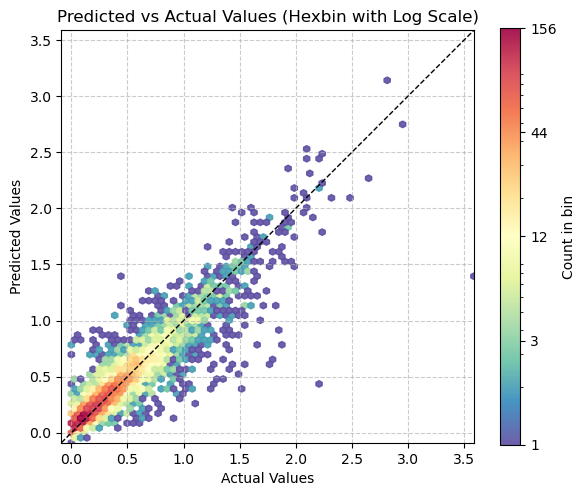

Min non-zero count in hexbins: 1.0
Max count in hexbins: 157.0


In [ ]:
plt.figure(figsize=(6, 6))

# Use logarithmic bins for the colormap
h = plt.hexbin(val_targets, val_preds, gridsize=65, 
               bins='log', cmap='Spectral_r', mincnt=1,
               alpha=0.9)

# Get the actual min and max counts from the hexbin data
counts = h.get_array()
min_count = counts[counts > 0].min()  # Minimum non-zero count
max_count = counts.max()

# Create a logarithmic colorbar
cb = plt.colorbar(h, label='Count in bin', shrink=0.73)
tick_locations = np.logspace(np.log10(min_count), np.log10(max_count), 5)
cb.set_ticks(tick_locations)
cb.set_ticklabels([f'{int(x)}' for x in tick_locations])

# Add the diagonal line
min_val = min(val_targets.min(), val_preds.min())
max_val = max(val_targets.max(), val_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Hexbin with Log Scale)')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.65)

# Set the same limits for both axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print the range of counts in the hexbins
print(f"Min non-zero count in hexbins: {min_count}")
print(f"Max count in hexbins: {max_count}")

In [ ]:
path_model = Path('./models')
learn.export(path_model / '0.pkl')

## Inference

In [ ]:
ossl_source = Path('../../_data/ossl-tfm/img')
learn.predict(ossl_source / '0a0a0c647671fd3030cc13ba5432eb88.png')

((0.5229991674423218,), tensor([0.5230]), tensor([0.5230]))

In [ ]:
df[df['fname'] == '0a0a0c647671fd3030cc13ba5432eb88.png']

,fname,kex
28867,0a0a0c647671fd3030cc13ba5432eb88.png,0.525379


In [ ]:
np.exp(3) - 1

19.085536923187668

## Experiments:


Color scale: `viridis` | Discretization: `percentiles = [i for i in range(60, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks |
|-----------|------------|----------------|--------|----------|----------------|------------|----------------|
| ResNet-18 | 100        | 1e-3           | 10     | 0.648    | 05:12          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     | 0.69     | 07:30          | No        | Yes             |
| ResNet-18 | 750 (original size)        |    1e-3        | 10     | 0.71          | 36:00          | No         | Yes             |
| ResNet-18 | 224        | 2e-3           | 20     |   0.704   | 07:30          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     |   0.71   | 07:00          | No        | No             |
    

Discretization: `percentiles = [i for i in range(20, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | No              | `viridis`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.71      | 05:12          | No         | No              | `jet`        |

From now on `with axis ticks` is always `No`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.71      | 05:12          | No         | None              | `jet`    |
| ResNet-18 | 224        | 2e-3         | 10     | 0.685      | 05:12          | No         | y range added              | `jet`    |


From now on random splitter with `10%` validation and random seed `41`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | Pre-train & normalize: True              | `jet`    |
| ResNet-18 | 224        | 2e-3          | 10     | 0.796     | 08:12          | No         | No Pre-train              | `jet`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.7     | 05:12          | No         | Pre-train & normalize: False            | `jet`    |
| ResNet-18 (id=0)| 224        | 2e-3          | 20     | **0.829**     | 08:12          | No         | No Pre-train (try 18 epochs)              | `jet`    |
